In [451]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv("insurance.csv")
display(df.head())
display(df.info())
display(df.describe())
display(df.isnull().sum())

# Veri seti hakkında genel bilgi sahibi edinmek için genel değerleri ve istatistikleri inceleyelim.

print(df.duplicated().sum()) # Tekrar eden satırları kontrol ediyoruz.
df = df.drop_duplicates() # Tekrar eden satırları kaldırıyoruz.

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

1


Veri seti hakkında genel bilgi edindik, sütun isimlerini öğrendik ve veri setinde eksik değer olmadığını öğrendik

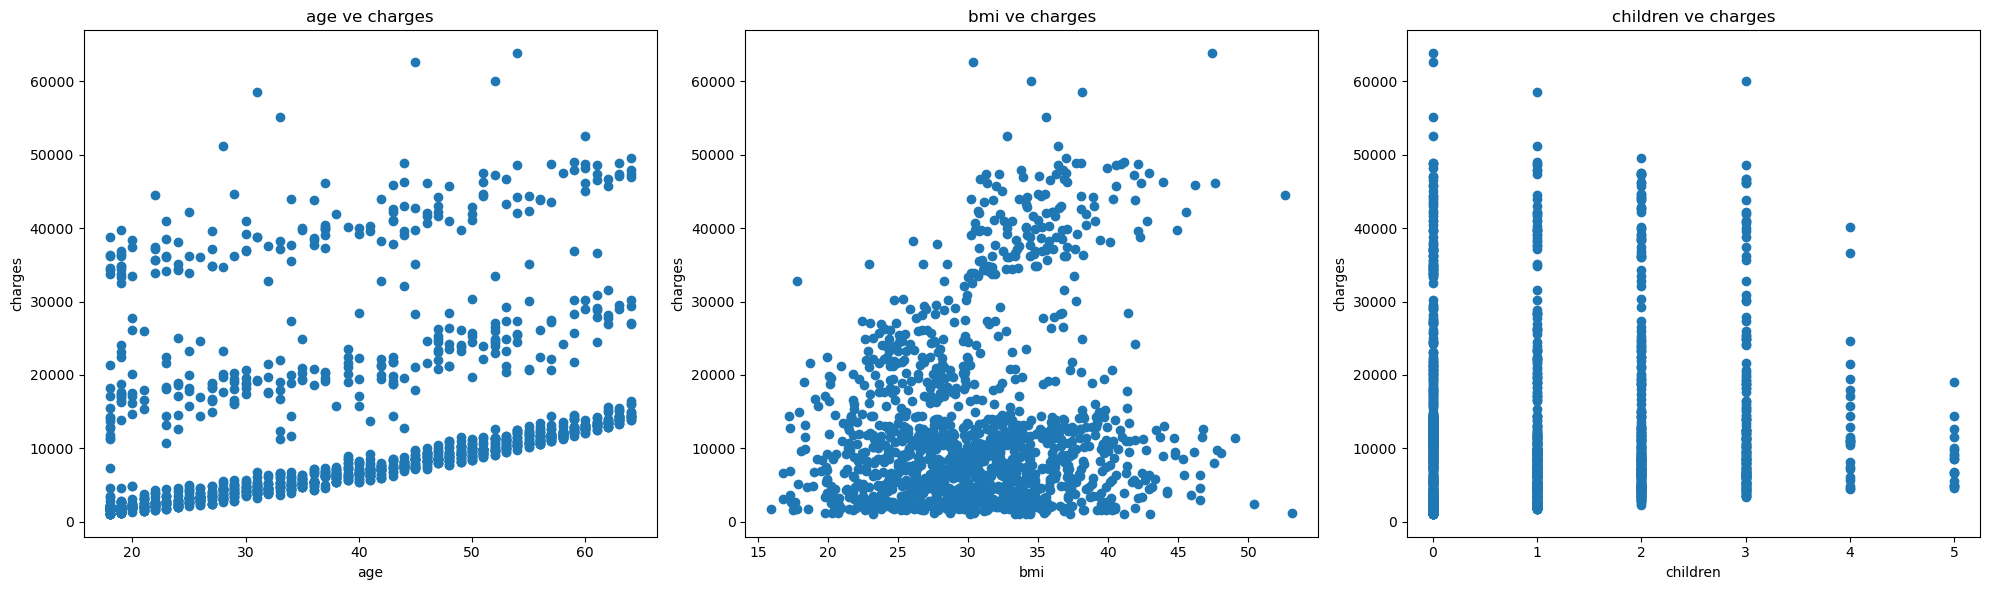

In [452]:
sayisal = df.select_dtypes(include=["int64", "float64"]).columns

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  
for i, col in enumerate(sayisal[:-1]):  # Charges vs Charges olmaması için, Charges sütununu çıkarıyoruz.
    axes[i].scatter(df[col], df["charges"])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("charges")
    axes[i].set_title(f"{col} ve charges")

# Charges ile ilişkili olan sayısal değişkenleri inceleyeliyoruz.

plt.tight_layout()
plt.show()

Age ile charges arasında pozitif korelasyon, children ve charges arasında negatif korelasyon olduğunu görüyoruz. bmi ile charges arasındaki ilişki hakkında yorum yapamıyoruz.

In [453]:
kategorik = df.select_dtypes(include=["object"]).columns # Kategorik değişkenleri seçiyoruz.

scaler = StandardScaler() # Veri setinde sayısal değerleri standartlaştırmak için StandardScaler kullanıyoruz.
df[sayisal] = scaler.fit_transform(df[sayisal])
df = pd.get_dummies(df, columns=kategorik, dtype=int) # Veri setinde kategorik değişkenleri sayısal değerlere dönüştürmek için pd.get_dummies kullanıyoruz.
df = df.drop(columns=["sex_female","smoker_no"])

display(df.head())

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.440418,-0.453160,-0.909234,0.297857,0,1,0,0,0,1
1,-1.511647,0.509422,-0.079442,-0.954381,1,0,0,0,1,0
2,-0.799350,0.383155,1.580143,-0.729373,1,0,0,0,1,0
3,-0.443201,-1.305052,-0.909234,0.719104,1,0,0,1,0,0
4,-0.514431,-0.292456,-0.909234,-0.777499,1,0,0,1,0,0


Standartlaştırma işlemi için MinMaxScaler kullanmama sebebim, değerleri 0-1 arasında çok küçük değerlere sıkıştırıyor. Değerler arasındaki fark çok küçük olduğu için, tahmin edilen değerler ile gerçek değerler arasındaki fark da çok küçük oluyor. Bu yüzden MSE değerleri çok küçük ve anlaşılmaz oluyor. MSE değerleri daha kolay okunabilmesi için StandardScaler kullandım. StandardScaler ile standartlışma ve get_dummies ile one-hot encoding dönüşümü yapılmıştır.

get_dummies fonksiyonunda drop_first = True yapıldığı taktirde "region_northeast" sütunu da siliniyor. Bu yüzden bazı sütunlar manuel olarak çıkarılmıştır.

charges             1.000000
smoker_yes          0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex_male            0.058044
region_northeast    0.005945
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64


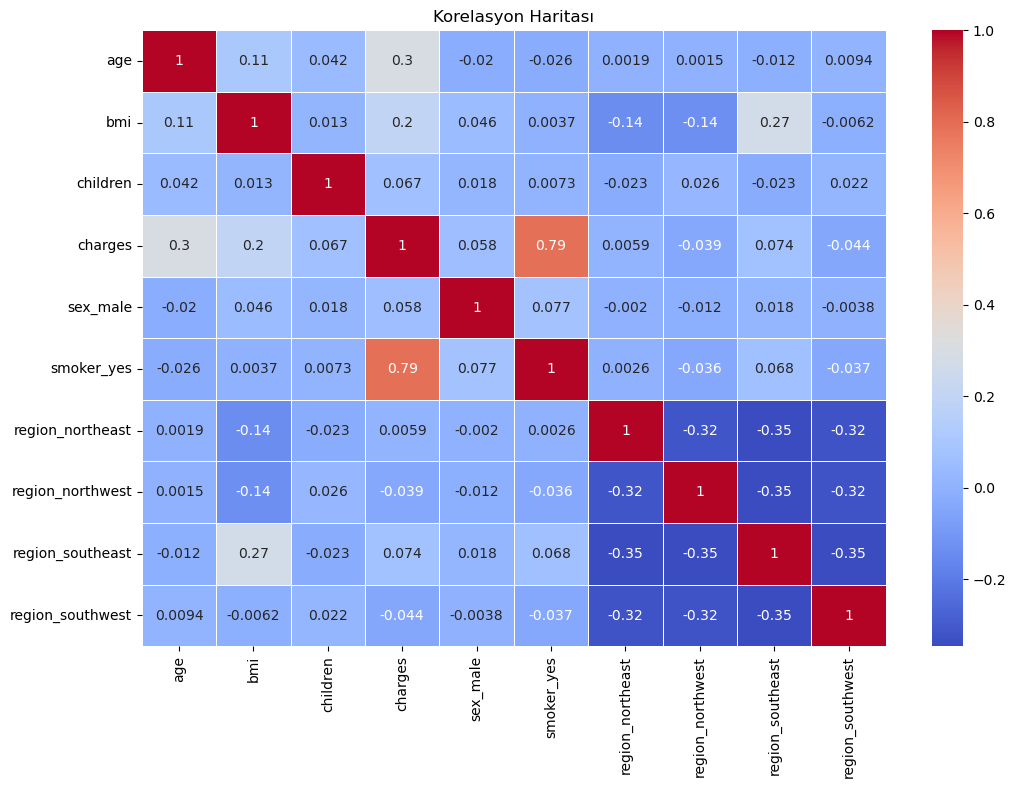

In [454]:
correlation_matrix = df.corr() # Korelasyon matrisini oluşturuyoruz.

print(correlation_matrix.sort_values(by="charges", ascending=False)["charges"])

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5) # Korelasyon matrisini çizdiriyoruz.
plt.title("Korelasyon Haritası")
plt.show()

Korelasyon Haritasına baktığmımızda, dikkate değer seviyede yüksek korelasyona sahip tek sütunun sigara içenler olduğunu görüyoruz.

In [455]:
X = df.drop(columns=["charges"])
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11) # Veri setini eğitim ve test setlerine ayırıyoruz.

model = LinearRegression()
model.fit(X_train, y_train)
# Model olarak lineer regression kullandık ve eğittik.

y_pred = model.predict(X_test) # Tahminatları yapıyoruz.
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression için MSE değeri: {mse:.2f} \nR² değeri: {r2:.2f}")

Linear Regression için MSE değeri: 0.17 
R² değeri: 0.81


Lineer Regresyon modelinin başarısını değerlendirmek için MSE ve R² değerlerini hesaplıyoruz ve değerler gayet yüksek çıkıyor.

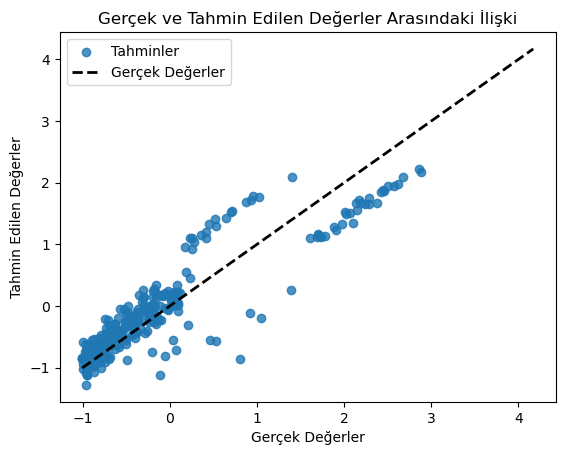

In [456]:
plt.scatter(y_test, y_pred, label="Tahminler", alpha=0.8) # Gerçek ve tahmin edilen değerleri çizdiriyoruz.
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Gerçek ve Tahmin Edilen Değerler Arasındaki İlişki")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2, label="Gerçek Değerler") # Gerçek değerleri temsil eden bir çizgi ekliyoruz.
plt.legend()
plt.show()

Tahmin edilen değerler ile Gerçek değerler arasındaki grafiği gözlemliyoruz.

In [457]:
y2 = y + abs(y.min()) + 1e-6 # Negatif değerleri pozitif hale getiriyoruz. (1e-6 değerini 0 olmaması için ekliyoruz.)
y_log = np.log(y2)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.20, random_state=42) # Logaritmik dönüşüm yaptığımızdan dolayı tekrardan train-test diye ayırıyoruz.
model = LinearRegression()
model.fit(X_train, y_train)
# Model olarak lineer regression kullandık ve eğittik.

y_pred = model.predict(X_test) # Tahminleri yapıyoruz.
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Logaritmik Linear Regression için MSE değeri: {mse:.2f} \nR² değeri: {r2:.2f}")

Logaritmik Linear Regression için MSE değeri: 0.49 
R² değeri: 0.73


Logaritmik dönüşüm yaptığımızda MSE ve R² değerlerinden görüyoruz ki modelimizin performansı düşüyor.

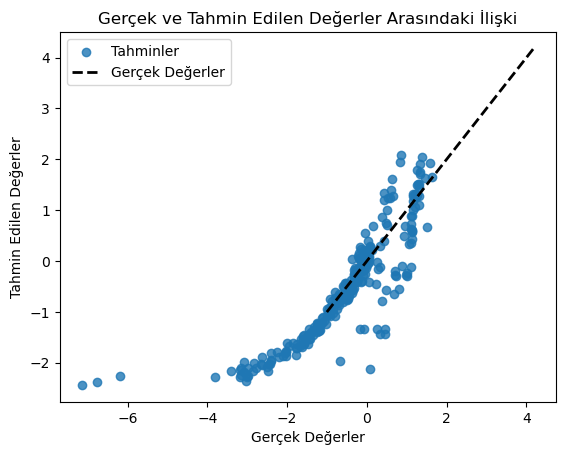

In [458]:
plt.scatter(y_test, y_pred, label="Tahminler", alpha=0.8) # Gerçek ve tahmin edilen değerler arasındaki ilişkiyi çizdiriyoruz.
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Gerçek ve Tahmin Edilen Değerler Arasındaki İlişki")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2, label="Gerçek Değerler") # Gerçek değerler için bir referans çizgisi ekliyoruz.
plt.legend()
plt.show()

Logaritmik dönüşüm aldıktan sonra lineer regresyon modelinde tahmin ve gerçek değerler arasındaki ilişki grafiğini gözlemliyoruz. Grafikten yola çıkarak, tahmin edilen değerlerin gerçek değerlerin çok gerisinde kaldığını gözlemleyebiliriz. Logaritmik dönüşüm, modelimizi olumsuz yönde etkiledi.

1. derece için; Polynomial Regression için MSE değeri: 0.17 	R² değeri: 0.81
2. derece için; Polynomial Regression için MSE değeri: 0.10 	R² değeri: 0.89
3. derece için; Polynomial Regression için MSE değeri: 0.12 	R² değeri: 0.86
4. derece için; Polynomial Regression için MSE değeri: 0.21 	R² değeri: 0.77
5. derece için; Polynomial Regression için MSE değeri: 0.71 	R² değeri: 0.21


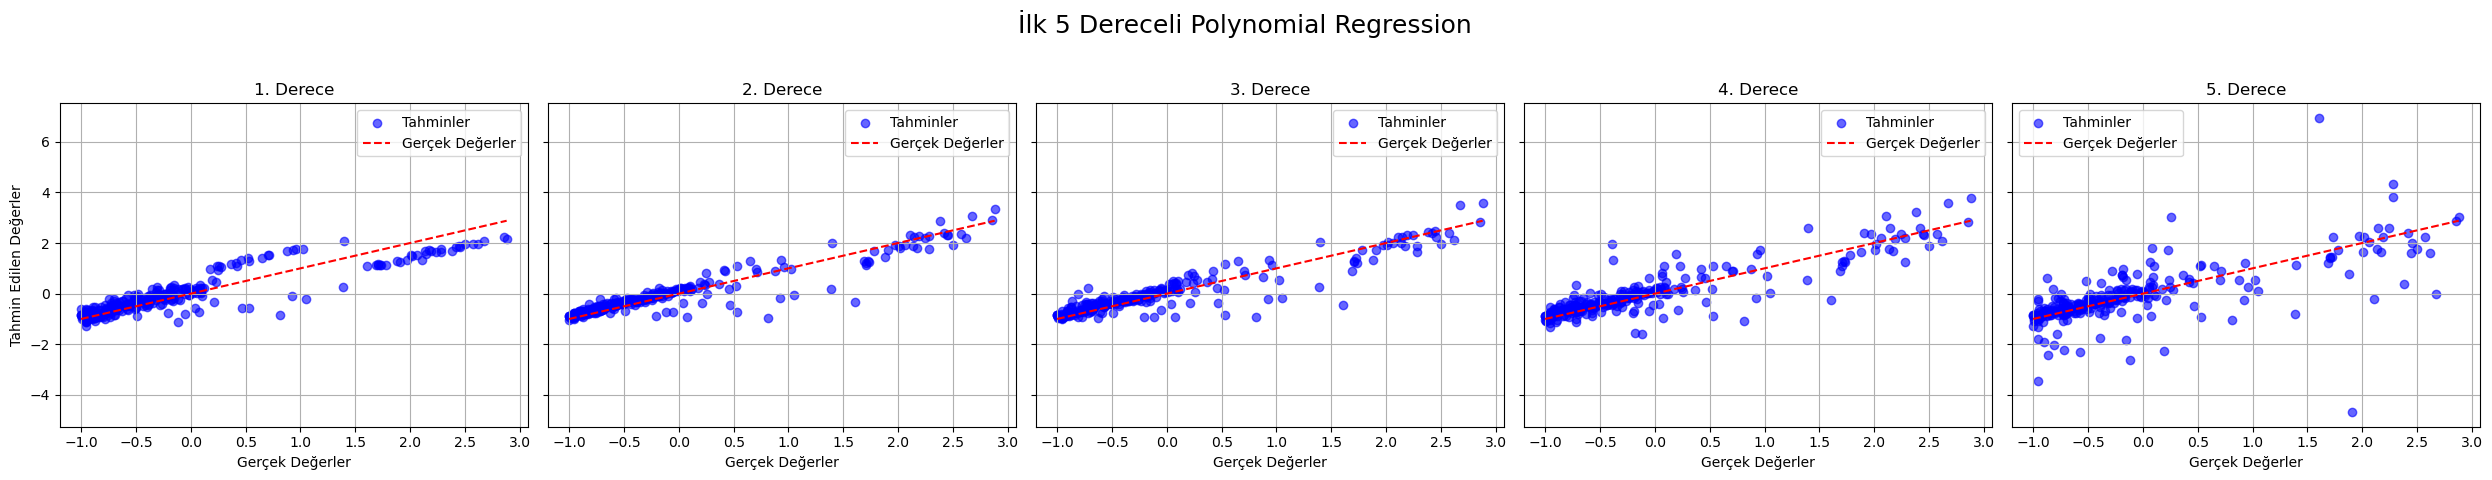

In [459]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11) # Veri setini tekrardan normal olacak şekilde ayırıyoruz.
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
fig.suptitle("İlk 5 Dereceli Polynomial Regression", fontsize=18)

for i, degree in enumerate(range(1, 6)):
    poly = PolynomialFeatures(degree=degree, include_bias=False) # 1-5 arası dereceler için polynomial regression yapıyoruz.
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    
    model = LinearRegression() # Model seçimi
    model.fit(X_poly_train, y_train) # Modeli eğitiyoruz.
    
    y_pred = model.predict(X_poly_test) # Tahminleri yaptırıyoruz.
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{degree}. derece için; Polynomial Regression için MSE değeri: {mse:.2f} \tR² değeri: {r2:.2f}")

    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Tahminler") # Tahmin edilen değerleri nokta olarak çizme
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Gerçek Değerler") # Gerçek değerleri çizgi olarak çizme
    
    ax.set_title(f"{degree}. Derece")
    ax.set_xlabel("Gerçek Değerler")
    if i == 0:
        ax.set_ylabel("Tahmin Edilen Değerler") # Sadece ilk grafikte y eksenine başlık atıyoruz.
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Grafiğin boyutunu düzenliyoruz.
plt.show()

Tek tek tüm dereceler için tahmin-gerçek değerler arasındaki ilişki grafikleri gözlemlenmiştir. Çizgi olarak gerçek değerler belirlenmiş ve tahminler mavi nokta ile ifade edilmiştir. Bu sayede gerçek değere olan uzaklığını görselden analiz edebiliriz.
Ayrıca R² değerlerine ve MSE değerlerine bakıldığında en iyi modelin 2. dereceden olduğunu görmekteyiz.

In [460]:
poly = PolynomialFeatures(degree=2, include_bias=False) # 2. dereceli polynomial regression için PolynomialFeatures kullanıyoruz.

poly.fit(X_train)
X_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

poly_ridge_model = Ridge(alpha=1) # Ridge regression için alpha değerini 1 olarak ayarlıyoruz.
poly_ridge_model.fit(X_poly, y_train) 
y_pred_ridge = poly_ridge_model.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred_ridge)
r2 = r2_score(y_test, y_pred_ridge)
print(f"Polynomial Ridge Regression için MSE değeri: {mse:.2f} \nR² değeri: {r2:.2f}")

poly_lasso_model = Lasso(alpha=0.1) # Lasso regression için alpha değerini 0.1 olarak ayarlıyoruz.
poly_lasso_model.fit(X_poly, y_train)
y_pred_lasso = poly_lasso_model.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)
print(f"\nPolynomial Lasso Regression için MSE değeri: {mse:.2f} \nR² değeri: {r2:.2f}")

Polynomial Ridge Regression için MSE değeri: 0.10 
R² değeri: 0.89

Polynomial Lasso Regression için MSE değeri: 0.20 
R² değeri: 0.77


Polinomal için Ridge aynı performansı vermesine rağmen Lasso modeli performansı düşürmüştür. Sebebini aşağıdaki grafikten görebilmekteyiz.

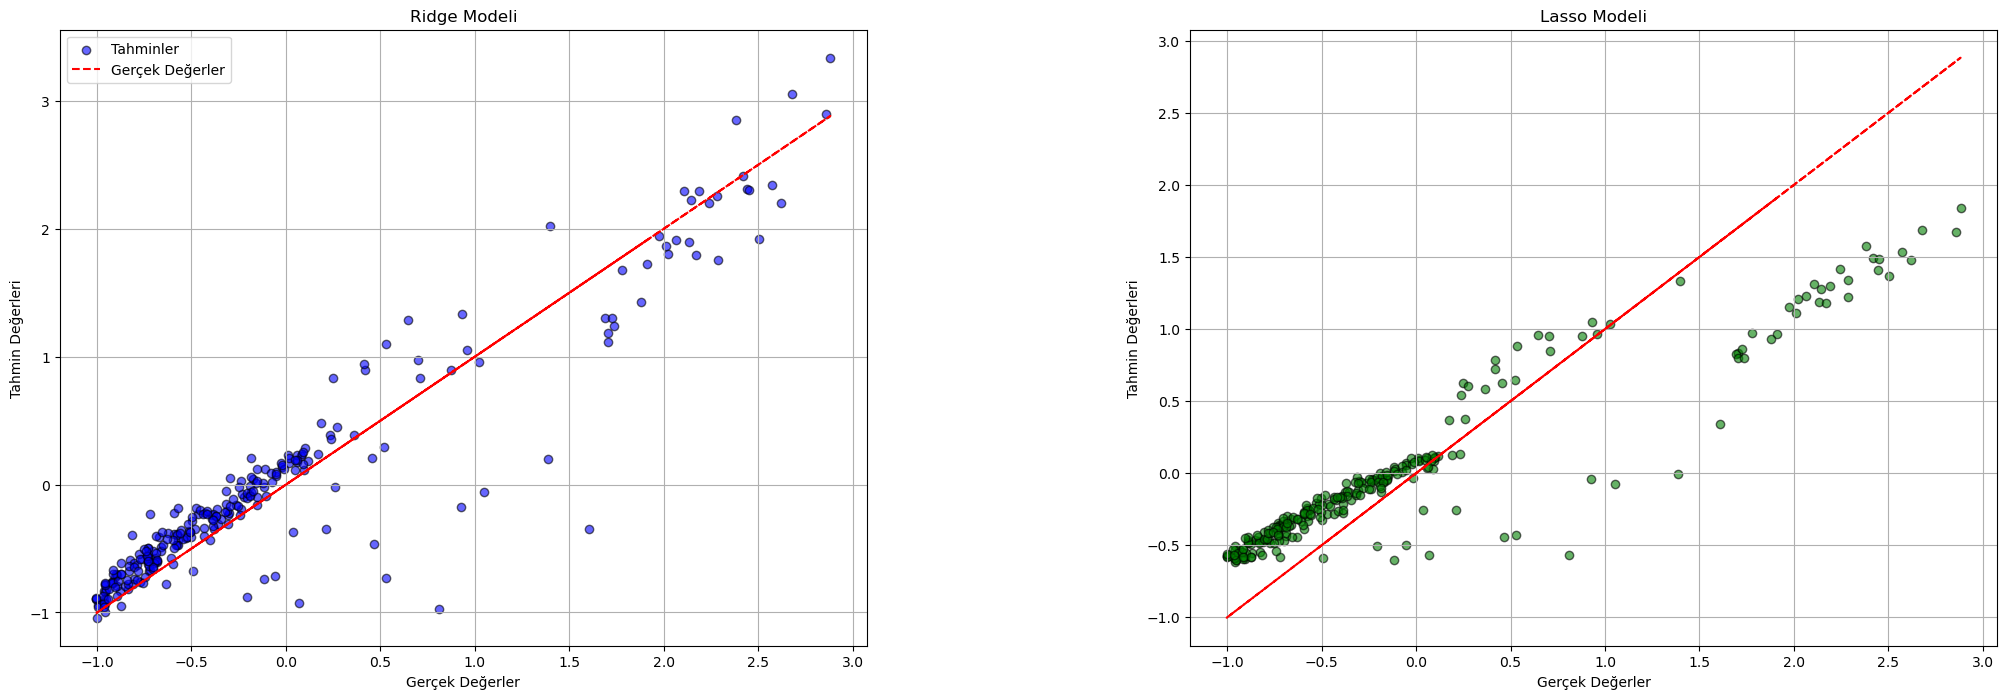

In [461]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

axes[0].scatter(y_test, y_pred_ridge, color="blue", alpha=0.6, edgecolor="k", label = "Tahminler") # Ridge modelinin tahmin edilen değerlerini nokta olarak çizme
axes[0].plot(y_test, y_test, color="red", linestyle="--", label = "Gerçek Değerler") # Gerçek değerleri çizgi olarak çizme
axes[0].legend()
axes[0].set_title("Ridge Modeli")
axes[0].set_xlabel("Gerçek Değerler")
axes[0].set_ylabel("Tahmin Değerleri")
axes[0].grid(True)

axes[1].scatter(y_test, y_pred_lasso, color="green", alpha=0.6, edgecolor="k", label = "Tahminler") # Lasso modelinin tahmin edilen değerlerini nokta olarak çizme
axes[1].plot(y_test, y_test, color="red", linestyle="--", label = "Gerçek Değerler") # Gerçek değerleri çizgi olarak çizme
axes[1].set_title("Lasso Modeli")
axes[1].set_xlabel("Gerçek Değerler")
axes[1].set_ylabel("Tahmin Değerleri")
axes[1].grid(True)

plt.subplots_adjust(wspace=0.4)
plt.show()

Ridge modeli, 2. dereceden polinom ile benzer grafiğe sahip olmasına rağmen, Lasso modeli yüksek cezalandırmaya sahip olduğundan dolayı tahminleri orantısız şekilde kötü etkilemiştir. Alpha değerinin yüksek olduğunu grafikten çıkarabilmekteyiz.

In [462]:
ridge_params = {"alpha": np.logspace(-3, 2, 50)} # 0.001 ile 100 arasında 50 farklı değer deniyoruz.
from sklearn.model_selection import GridSearchCV
ridge_model = Ridge()
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring="r2") # En iyi parametreleri bulmak için GridSearchCV kullanıyoruz.
ridge_grid.fit(X_train, y_train)

print(f"En iyi Ridge model parametreleri: {ridge_grid.best_params_}") # en iyi parametreleri yazdırıyoruz.
ridge_best = ridge_grid.best_estimator_ # En iyi parametreleri kaydediyoruz.

poly_ridge_model = Ridge(alpha=ridge_best.alpha) # En iyi parametreleri kullanarak Ridge modelini oluşturuyoruz.
poly_ridge_model.fit(X_poly, y_train)

y_pred_ridge = poly_ridge_model.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred_ridge)
r2 = r2_score(y_test, y_pred_ridge)
print(f"Polynomial Ridge Regression için MSE değeri: {mse:.2f} \nR² değeri: {r2:.2f}")

lasso_params = {"alpha": np.logspace(-3, 2, 50)} # 0.001 ile 100 arasında 50 farklı değer deniyoruz.
lasso_model = Lasso()

lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=4, scoring="r2") # En iyi parametreleri bulmak için GridSearchCV kullanıyoruz.
lasso_grid.fit(X_train, y_train)
print(f"\nEn iyi Lasso model parametreleri: {lasso_grid.best_params_}") 
lasso_best = lasso_grid.best_estimator_

poly_lasso_model = Lasso(alpha=lasso_best.alpha) # En iyi parametreleri kullanarak Lasso modelini oluşturuyoruz.
poly_lasso_model.fit(X_poly, y_train)
X_test_poly = poly.transform(X_test)

y_pred_lasso = poly_lasso_model.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)
print(f"Polynomial Lasso Regression için MSE değeri: {mse:.2f} \nR² değeri: {r2:.2f}")

En iyi Ridge model parametreleri: {'alpha': 0.9102981779915218}
Polynomial Ridge Regression için MSE değeri: 0.10 
R² değeri: 0.89

En iyi Lasso model parametreleri: {'alpha': 0.005179474679231213}
Polynomial Lasso Regression için MSE değeri: 0.09 
R² değeri: 0.90


Ridge modeli için, en iyi alpha değeri modelin performansını değiştirmese bile, Lasso modeli için Performans büyük ölçüde artmıştır. Ancak alpha değeri 0.001 seçildiğinden dolayı cezalandırma neredeyse hiç yapılmamaktadır.

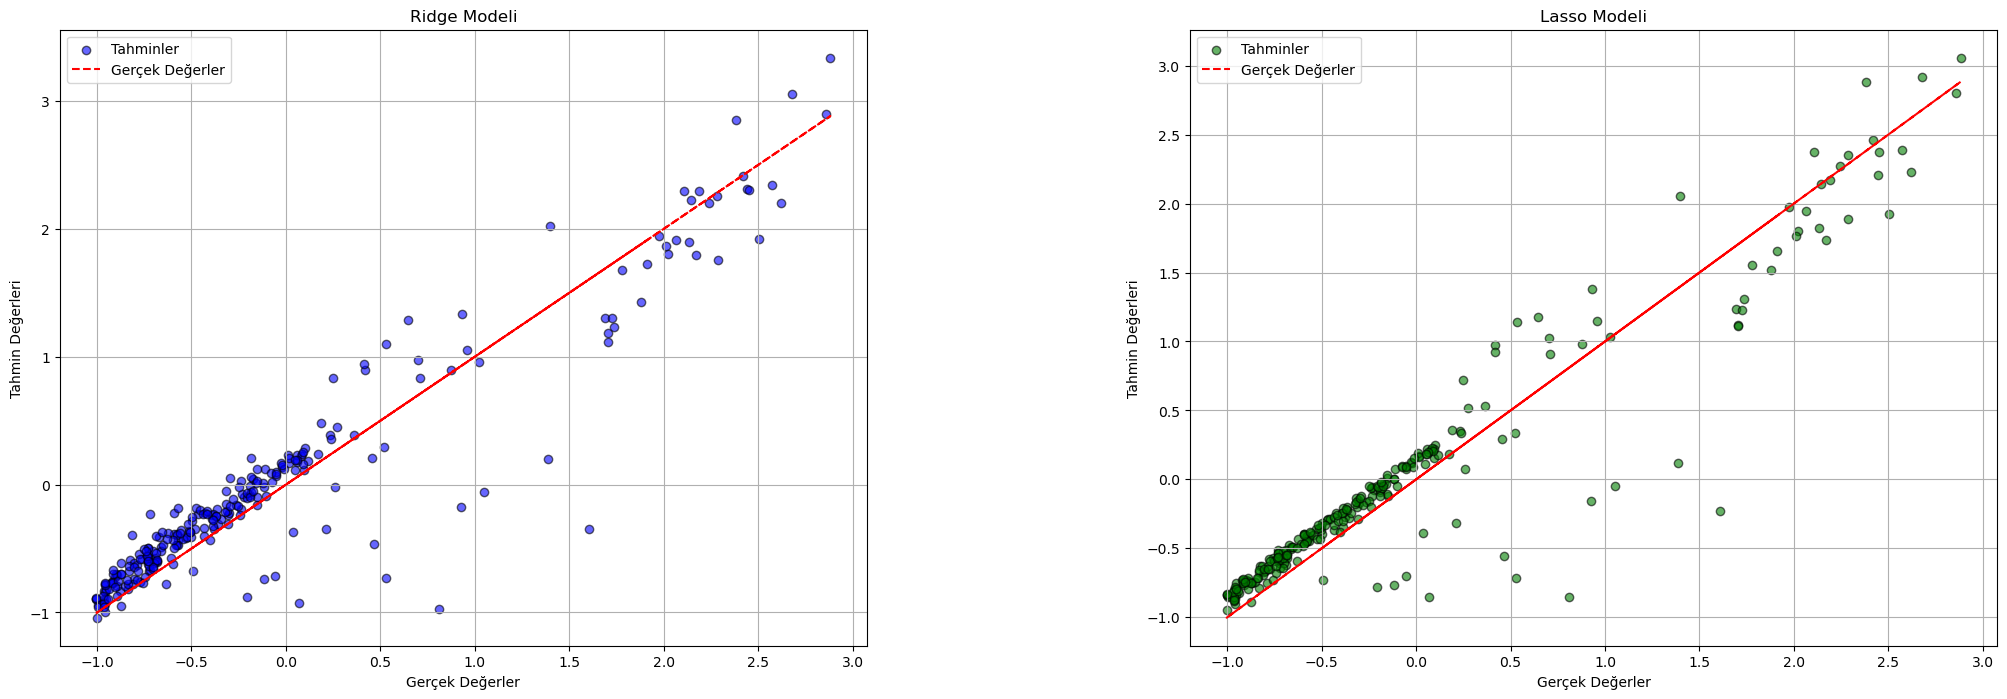

In [463]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

axes[0].scatter(y_test, y_pred_ridge, color="blue", alpha=0.6, edgecolor="k", label = "Tahminler") # Ridge modelinin tahminlerini çiziyoruz.
axes[0].plot(y_test, y_test, color="red", linestyle="--", label = "Gerçek Değerler") # Gerçek değerlerin çizgisini ekliyoruz.
axes[0].set_title("Ridge Modeli")
axes[0].set_xlabel("Gerçek Değerler")
axes[0].set_ylabel("Tahmin Değerleri")
axes[0].grid(True)

axes[1].scatter(y_test, y_pred_lasso, color="green", alpha=0.6, edgecolor="k", label = "Tahminler") # Lasso modelinin tahminlerini çiziyoruz.
axes[1].plot(y_test, y_test, color="red", linestyle="--", label = "Gerçek Değerler") # Gerçek değerlerin çizgisini ekliyoruz.
axes[1].set_title("Lasso Modeli")
axes[1].set_xlabel("Gerçek Değerler")
axes[1].set_ylabel("Tahmin Değerleri")
axes[1].grid(True)

axes[0].legend()
axes[1].legend()
plt.subplots_adjust(wspace=0.4)
plt.show()

Ridge için gözle görülür bir fark olmamasına rağmen, Lasso modeli için alpha değeri çok düşük olduğundan dolayı neredeyse hiç cezalandırma olmamaktadır. Bu yüzden Lasso modelimiz de Ridge modelimiz gibi 2. dereceden polinomal regresyon ile neredeyse aynı grafiğe dönmüştür.